### 元素周期表绘制

>https://ywwang0.github.io/2020/11/09/python%E7%BB%98%E5%88%B6%E5%85%83%E7%B4%A0%E5%91%A8%E6%9C%9F%E8%A1%A8/

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from pymatgen.core.periodic_table import Element


class periodic_table(object):
    """
    frame: str or dict, describe shapes of element cells.
        str: patch class name under matplotlib.patches.
        dict: {
            "shape": patch class name,
            "parms": width, height and other parms, needed for "shape",
            "kparms": kparms, supported by "shape"
        }
    colors: dict, custom frame and background colors for elements.
        {
            "frame": str, list
            "background": str, list, {"depend_on": data_key [, "cmp": color map, "cbar": True]}
        }
        if you use a gradient, color will based on the data from Element().data or you provide.
        depend_on specify which data you want to use.
    label: dict or function(not supported yet).
        dict: {
            "label1": [element symbols or atomic indexes],
            ...
        }
        or more detail:
        dict: {
            "label1": {
                "elements": [element symbols or atomic indexes],
                "color": not necessary
            }
            ...
        }
        function: func(element symbol or atomic index) returns color and label
    text: text content and format within element cells (not supported yet).
    data: data beside pymatgen or you want overide for pymatgen
        {symbol: {k1: v1, k2:v2}, ...}
    """

    def __init__(
        self, frame=None, colors=None, labels=None, text=None, data=None
    ):
        self.frame = frame or {}
        if isinstance(self.frame, str):
            self.frame = {"shape": self.frame or None}
        self.frame.setdefault("shape", "Rectangle")
        self.frame.setdefault(
            "parms_orig", self.frame.get("parms", [1.0, 1.0])
        )
        self.frame.setdefault("kparms", {})
        self.colors = colors or {}
        self.colors.setdefault("frame", "black")
        self.colors.setdefault("background", "none")
        if (not labels) or "background" in labels or "frame" in labels:
            self.labels = labels or {}
        else:
            self.labels = {"background": labels}
        self._text = text or None
        self._data = {
            Element.from_Z(i).symbol: {
                "Symbol": Element.from_Z(i).symbol,
                **Element.from_Z(i).data,
            }
            for i in range(1, 104)
        }
        if data:
            [self._data[k].update(data[k]) for k in data]

    def get_frame(self):
        self.frame["parms"] = list(self.frame["parms_orig"])
        if self.frame["shape"] == "FancyBboxPatch":
            self.frame["kparms"].setdefault("boxstyle", "round, pad=0.1")
            pad = float(
                [
                    *re.findall(
                        "pad=(\d+[.]\d+)", self.frame["kparms"]["boxstyle"]
                    ),
                    0.3,
                ][0]
            )
            self.frame["parms"][0:2] = list(
                np.array(self.frame["parms_orig"][0:2]) - 2 * pad
            )
        try:
            return getattr(mpatches, self.frame["shape"])
        except AttributeError:
            raise ValueError("Unsupported shape error")

    def get_xys(self):
        width_and_height = np.array(self.frame["parms_orig"][0:2])
        text_shift = self.frame.get(
            "text_shift", np.array([0.5, 0.5]) * width_and_height
        )
        if self.frame["shape"] == "FancyBboxPatch":
            text_shift -= 0.10 * width_and_height

        elements = [Element.from_Z(i) for i in range(1, 104)]
        group_and_rows = [np.array([el.group, el.row]) for el in elements]
        frame_xys = [
            np.array([1, -1]) * gr * width_and_height for gr in group_and_rows
        ]
        text_xys = [text_shift + fxy for fxy in frame_xys]
        return frame_xys, text_xys

    def get_colors_and_legend(self):
        for v in self.colors.values():
            if isinstance(v, list) and len(v) != len(self._data):
                raise ValueError(
                    "Length of color list should be compatible with Elements."
                )
        default_color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        default_edgecolor = ["black", self.colors["frame"]][
            isinstance(self.colors["frame"], str)
        ]
        default_facecolor = ["none", self.colors["background"]][
            isinstance(self.colors["background"], str)
        ]

        colors = {
            "edgecolors": self.colors.get("frame", default_edgecolor),
            "facecolors": [
                self.colors.get("background", default_facecolor),
                None,
            ][isinstance(self.colors["background"], dict)],
        }
        legend_handles = []

        for k, v in colors.items():
            labels = self.labels.get(
                {"edgecolors": "frame", "facecolors": "background"}[k], None
            )
            if labels:
                if not v:
                    raise ValueError(
                        "Gradient mapped background can't be labelled."
                    )
                if isinstance(colors[k], str):
                    colors[k] = [colors[k]] * len(self._data)
                if isinstance(list(labels.values())[0], list):
                    labels = {
                        lk: {"elements": lv} for lk, lv in labels.items()
                    }
                for i, l in enumerate(labels):
                    label = labels[l]
                    label.setdefault("label", l)
                    indexes = [Element(s).Z - 1 for s in label["elements"]]
                    label.setdefault("color", default_color_cycle[i])
                    for j in indexes:
                        colors[k][j] = label["color"]
                    label.setdefault("frame_kparms", {})
                    for lkk in ["edgecolor", "facecolor"]:
                        label["frame_kparms"].setdefault(lkk, "none")
                    label["frame_kparms"][k[0:-1]] = label["color"]

                    patch_legend = mpatches.Patch(
                        label=label["label"], **label["frame_kparms"]
                    )
                    legend_handles.append(patch_legend)

        return colors, legend_handles

    def get_plot(self, title=None, figsize=None, legend_kparms={}):
        fig, ax = plt.subplots(figsize=figsize)

        frame_xys, text_xys = self.get_xys()
        colors, legend_handles = self.get_colors_and_legend()

        frame = self.get_frame()
        frames = [
            frame(xy, *self.frame["parms"], **self.frame["kparms"])
            for xy in frame_xys
        ]
        collection = PatchCollection(frames, **colors)
        ax.add_collection(collection)
        [
            ax.text(
                *text_xys[i],
                Element.from_Z(i + 1).symbol,
                horizontalalignment="center",
                verticalalignment="center",
                family="Times New Roman",
                size="x-large"
            )
            for i in range(len(self._data))
        ]

        if legend_handles:
            legend_kparms.update({"handles": legend_handles})
            legend_kparms.setdefault("loc", "upper center")
            legend_kparms.setdefault("bbox_to_anchor", (0.41, 1.0))
            legend_kparms.setdefault("fontsize", "x-large")
            ax.legend(**legend_kparms)
        if title:
            plt.title(title, fontsize=28)
        plt.axis("equal")
        plt.axis("off")
        plt.tight_layout()
        return plt

    def show(self, title=None, figsize=None):
        plt = self.get_plot(title=title, figsize=figsize)
        plt.show()

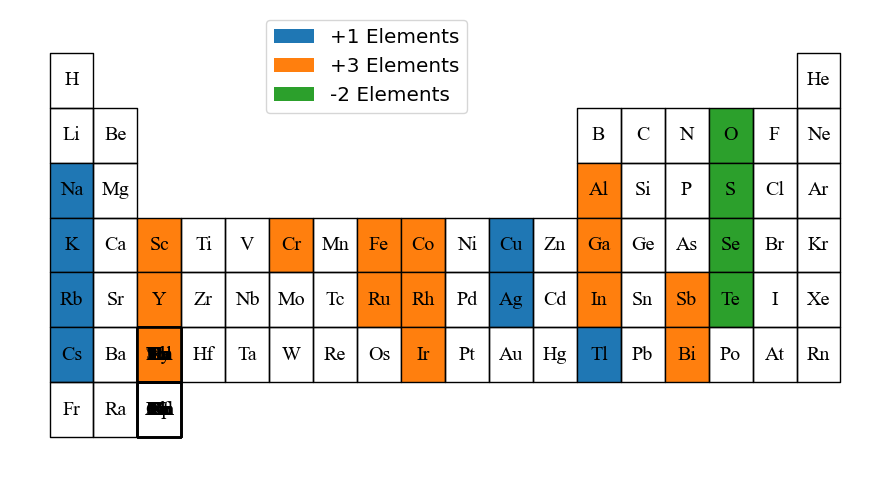

In [2]:
# 使用例子1
p = periodic_table(
    frame={"shape": "Rectangle", "parms": [1.0, 1.25]},
    labels={
        "background": {
            "+1 Elements": ["Na", "K", "Rb", "Ag", "Cs", "Tl", "Cu"],
            "+3 Elements": [
                "Al",
                "Sc",
                "Cr",
                "Fe",
                "Co",
                "Ga",
                "Y",
                "Ru",
                "Rh",
                "In",
                "Sb",
                "La",
                "Ce",
                "Gd",
                "Ir",
                "Bi",
            ],
            "-2 Elements": ["O", "S", "Se", "Te"],
        }
    },
)
pplt = p.get_plot(figsize=(9, 5))
pplt.show()

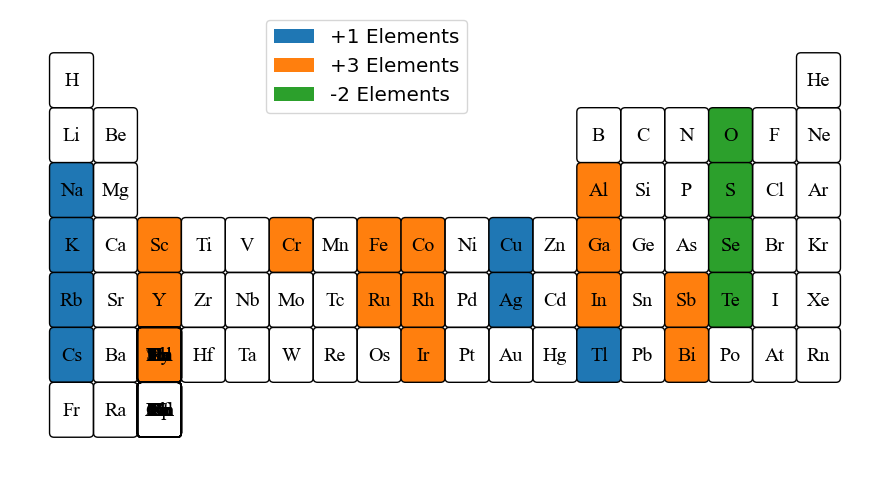

In [3]:
# 使用例子2
plt.close()
p = periodic_table(
    frame={"shape": "FancyBboxPatch", "parms": [1.0, 1.25]},
    labels={
        "background": {
            "+1 Elements": ["Na", "K", "Rb", "Ag", "Cs", "Tl", "Cu"],
            "+3 Elements": [
                "Al",
                "Sc",
                "Cr",
                "Fe",
                "Co",
                "Ga",
                "Y",
                "Ru",
                "Rh",
                "In",
                "Sb",
                "La",
                "Ce",
                "Gd",
                "Ir",
                "Bi",
            ],
            "-2 Elements": ["O", "S", "Se", "Te"],
        }
    },
)
pplt = p.get_plot(figsize=(9, 5))
# pplt.savefig("periodic_table.pdf", transparent=True)
pplt.show()

In [3]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge, factor_cmap
from bokeh.io import export_png, export_svgs

output_notebook()

periods = ["I", "II", "III", "IV", "V", "VI", "VII"]
groups = [str(x) for x in range(1, 19)]

df = elements.copy()
df["atomic mass"] = df["atomic mass"].astype(str)
df["group"] = df["group"].astype(str)
df["period"] = [periods[x - 1] for x in df.period]
df = df[df.group != "-"]
df = df[df.symbol != "Lr"]
df = df[df.symbol != "Lu"]

cmap = {
    "alkali metal": "#a6cee3",
    "alkaline earth metal": "#1f78b4",
    "metal": "#d93b43",
    "halogen": "#999d9a",
    "metalloid": "#e08d49",
    "noble gas": "#eaeaea",
    "nonmetal": "#f1d4Af",
    "transition metal": "#599d7A",
}

source = ColumnDataSource(df)

p = figure(
    # plot_width=900,
    # plot_height=500,
    title="Periodic Table (omitting LA and AC Series)",
    x_range=groups,
    y_range=list(reversed(periods)),
    toolbar_location=None,
    tools="hover",
)

p.rect(
    "group",
    "period",
    0.95,
    0.95,
    source=source,
    fill_alpha=0.5,
    # legend="metal",
    color=factor_cmap(
        "metal", palette=list(cmap.values()), factors=list(cmap.keys())
    ),
)

text_props = {
    "source": source,
    "text_align": "left",
    "text_baseline": "middle",
}

x = dodge("group", -0.4, range=p.x_range)

r = p.text(x=x, y="period", text="symbol", **text_props)
r.glyph.text_font_style = "bold"

r = p.text(
    x=x,
    y=dodge("period", 0.3, range=p.y_range),
    text="atomic number",
    **text_props
)
r.glyph.text_font_size = "11px"

r = p.text(
    x=x, y=dodge("period", -0.35, range=p.y_range), text="name", **text_props
)
r.glyph.text_font_size = "7px"

r = p.text(
    x=x,
    y=dodge("period", -0.2, range=p.y_range),
    text="atomic mass",
    **text_props
)
r.glyph.text_font_size = "7px"

p.text(
    x=["3", "3"],
    y=["VI", "VII"],
    text=["LA", "AC"],
    text_align="center",
    text_baseline="middle",
)

p.hover.tooltips = [
    ("Name", "@name"),
    ("Atomic number", "@{atomic number}"),
    ("Atomic mass", "@{atomic mass}"),
    ("Type", "@metal"),
    ("CPK color", "$color[hex, swatch]:CPK"),
    ("Electronic configuration", "@{electronic configuration}"),
]

p.outline_line_color = None
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_standoff = 0
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
p.output_backend = "svg"
# export_png(p, filename="plot.png")

Loading BokehJS ...

/var/folders/wn/hl0v7q1j64j3rh1n8z6g7f8c0000gn/T/ipykernel_10934/3495956789.py:111: UserWarning: 
You are attempting to set `plot.legend.orientation` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.orientation = "horizontal"
/var/folders/wn/hl0v7q1j64j3rh1n8z6g7f8c0000gn/T/ipykernel_10934/3495956789.py:112: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.location = "top_center"
